In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM,Dense,BatchNormalization,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('../data/one_feature_data.csv')
data.shape

(3809, 1)

### Train, Val, Test spliting

In [3]:
train_org = data.iloc[:3048,:]
test = data.iloc[3048:,:]
train_org.shape, test.shape   

((3048, 1), (761, 1))

In [4]:
scaler = MinMaxScaler()
train_org = scaler.fit_transform(train_org)
test = scaler.transform(test)

In [5]:
train = train_org[:2287, :]
val = train_org[2287:, :]
train.shape, val.shape                     # train: 2287 seqs, val: 761 seqs, test: 761 seqs

((2287, 1), (761, 1))

In [6]:
X_train=[]
y_train=[]

for i in range(0,train.shape[0]-31):         # idea: use 30 previous day to predict next 1 day
    X_train.append(train[i:i+30,:])
    y_train.append(train[i+30:i+31,:])

X_train,y_train=np.array(X_train),np.array(y_train)
X_train.shape,y_train.shape

((2256, 30, 1), (2256, 1, 1))

In [7]:
X_val=[]
y_val=[]

for i in range(0,val.shape[0]-31):         # idea: use 30 previous day to predict next 1 day
    X_val.append(val[i:i+30,:])
    y_val.append(val[i+30:i+31,:])

X_val,y_val=np.array(X_val),np.array(y_val)
X_val.shape,y_val.shape

((730, 30, 1), (730, 1, 1))

In [8]:
X_test=[]
y_test=[]

for i in range(0,test.shape[0]-31):         # idea: use 30 previous day to predict next 1 day
    X_test.append(test[i:i+30,:])
    y_test.append(test[i+30:i+31,:])

X_test,y_test=np.array(X_test),np.array(y_test)
X_test.shape,y_test.shape

((730, 30, 1), (730, 1, 1))

### Modeling

In [9]:
model=Sequential() 

model.add(LSTM(units = 16,activation='tanh',return_sequences=False,input_shape=(X_train.shape[1],X_train.shape[2]))) 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1)) 

In [10]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='mean_squared_error')

In [11]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

Train on 2256 samples, validate on 730 samples
Epoch 1/50
2256/2256 [==============================] - 5s 2ms/sample - loss: 0.1181 - val_loss: 0.2229
Epoch 2/50
2256/2256 [==============================] - 0s 207us/sample - loss: 0.0375 - val_loss: 0.2077
Epoch 3/50
2256/2256 [==============================] - 1s 223us/sample - loss: 0.0163 - val_loss: 0.1938
Epoch 4/50
2256/2256 [==============================] - 0s 211us/sample - loss: 0.0089 - val_loss: 0.1697
Epoch 5/50
2256/2256 [==============================] - 0s 219us/sample - loss: 0.0060 - val_loss: 0.1370
Epoch 6/50
2256/2256 [==============================] - 1s 246us/sample - loss: 0.0039 - val_loss: 0.0945
Epoch 7/50
2256/2256 [==============================] - 1s 223us/sample - loss: 0.0024 - val_loss: 0.0635
Epoch 8/50
2256/2256 [==============================] - 1s 226us/sample - loss: 0.0021 - val_loss: 0.0304
Epoch 9/50
2256/2256 [==============================] - 1s 223us/sample - loss: 0.0017 - val_loss: 0.0076
E

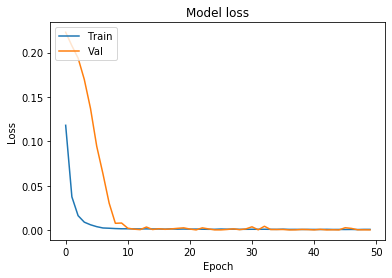

In [12]:
epoch_range=range(1,50+1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.xticks([x for x in range(epoch+1)])
plt.legend(['Train','Val'],loc='upper left')
plt.show()

### Evaluation

In [13]:
y_pred = model.predict(X_test)
y_pred.shape

(730, 1)

In [14]:
y_pred = scaler.inverse_transform(y_pred)
y_pred.shape

(730, 1)

In [15]:
scale = scaler.scale_[0]
scale

0.0013565203795903229

In [16]:
bias = scaler.min_[0]
bias

-0.06702540200800232

In [17]:
y_test = (y_test-bias)/scale

In [18]:
y_test = y_test.reshape(730, 1)

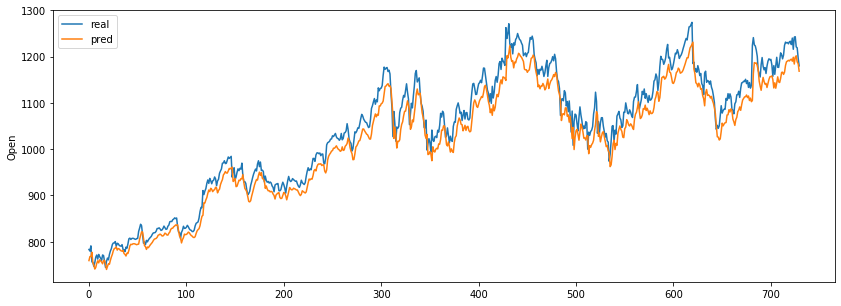

In [19]:
plt.figure(figsize=(14,5))
plt.plot(y_test,label='real')
plt.plot(y_pred,label='pred')
plt.ylabel('Open')
plt.legend()
plt.show()

In [20]:
model.save('../model/LSTM_seq2vec.h5')